# Homework 1. Part 3.3

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import DataLoader

In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

### Modifiable model

In [3]:
class ChangeableNetwork(nn.Module):
    def __init__(self, modification=512):
        super().__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(28*28, modification),
            nn.ReLU(),
            nn.Linear(modification,modification),
            nn.ReLU(),
            nn.Linear(modification, 10),
        )

    def forward(self, x):
        flat = nn.Flatten()
        x = flat(x)
        logits = self.linear_relu(x)
        return logits

### Utility Functions

In [4]:
def cnt_model_params(model):
    """Count model parameters"""
    count = 0
    with torch.no_grad():
        for param in model.parameters():
            count+=param.numel()
    return count

def display_model_info(model_name, model):
    """ Display model information"""
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Module):
            count+=1
    display(model)
    display(f"{model_name}. parameters: {cnt_model_params(model)}")

In [5]:
# Randomly changed the lavels on the training dataset. Kept labels the same on test dataset.
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())


### Training & eval loops

In [6]:
def nmist_train_loop(dataloader, model, loss_fn, optimize):
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)
    sensitivity = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.clone().detach().requires_grad_(True).to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        gradloss = torch.autograd.grad(loss, y_pred, retain_graph = True)
        sensitivity += sum([torch.linalg.matrix_norm(g_loss, ord='fro').item() for g_loss in gradloss])
        loss.backward(retain_graph = True)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
        optimize.step()
        

        
        
        #grad_all = 0
        #for k, params in  model.named_parameters():
        #    if params.grad is not None:
        #        if 'weight' in k:
        #            sensitivity+= torch.linalg.norm(params.grad, ord='fro')

                #sensitivity += torch.linalg.norm(loss.grad, ord='fro')
                #grad = params.grad.detach().cpu().data.norm(2)
                #grad_all += grad.item() ** 2
                #grad = (params.grad.cpu().data.numpy() ** 2).sum()
            #grad_all +=grad

        
    train_loss /= num_batches
    correct /=size
    sensitivity / num_batches
    return train_loss, correct, sensitivity
        
def nmist_val_loop(dataloader, model, loss_fn):
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct    

## Flatness v.s. Generalization part2

In [7]:
# create models and with different Hidden values
models = [ChangeableNetwork(512) for _ in range(5)]
for idx, model in enumerate(models):
    display_model_info(idx, model)
    

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'0. parameters: 669706'

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'1. parameters: 669706'

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'2. parameters: 669706'

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'3. parameters: 669706'

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'4. parameters: 669706'

In [8]:
# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20
lr = 1e-3

batch_sizes = torch.linspace(64, 1024, steps=5, dtype=int).detach().cpu().numpy().tolist()

fit_df = pd.DataFrame()
display(f'Batch sizes: {batch_sizes}')

for batch_size, model in zip(batch_sizes, models):
    optimizer1 = torch.optim.SGD(model.parameters(), lr=lr)
    display(f"Training & eval: Model with batch size: {batch_size}")

    # Dataloader
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
   
    for epoch in range(epochs):
        train_loss, t_correct, sensitivity = nmist_train_loop(training_dl, model, loss_fn, optimizer1)
        val_loss, v_correct = nmist_val_loop(test_dl, model, loss_fn)
        display(f'Epoch {epoch}. Sensitivity: {sensitivity}. Training_loss: {train_loss}. Val_loss: {val_loss}. Training_accuracy: {t_correct}. Val_accuracy: {v_correct}')
    display("Done")
    
    if fit_df.empty:
        fit_df = pd.DataFrame([[epoch, train_loss, val_loss, t_correct, v_correct, batch_size, sensitivity]], columns=['epoch','train_loss','val_loss', 'train_acc', 'v_acc','batch_size', 'sensitivity'])
    else:
        fit_df = pd.concat([fit_df, pd.DataFrame([[epoch, train_loss, val_loss, t_correct, v_correct, batch_size, sensitivity]], columns=['epoch','train_loss','val_loss', 'train_acc', 'v_acc','batch_size', 'sensitivity'])])

'Batch sizes: [64, 304, 544, 784, 1024]'

'Training & eval: Model with batch size: 64'

'Epoch 0. Sensitivity: 111.03392051905394. Training_loss: 2.2828778737643636. Val_loss: 2.2595717390631416. Training_accuracy: 0.24338333333333334. Val_accuracy: 0.4325'

'Epoch 1. Sensitivity: 110.3982025384903. Training_loss: 2.2344136441440217. Val_loss: 2.2005825634974583. Training_accuracy: 0.5426333333333333. Val_accuracy: 0.6215'

'Epoch 2. Sensitivity: 109.3403313010931. Training_loss: 2.1600202019534893. Val_loss: 2.1022395844672137. Training_accuracy: 0.6489666666666667. Val_accuracy: 0.6733'

'Epoch 3. Sensitivity: 107.22717898339033. Training_loss: 2.0301853363702036. Val_loss: 1.928460572175919. Training_accuracy: 0.6745833333333333. Val_accuracy: 0.6862'

'Epoch 4. Sensitivity: 102.8582665771246. Training_loss: 1.8096751035657772. Val_loss: 1.6518212237935157. Training_accuracy: 0.6920333333333333. Val_accuracy: 0.7118'

'Epoch 5. Sensitivity: 95.31689491122961. Training_loss: 1.5037394773477175. Val_loss: 1.3226313234134843. Training_accuracy: 0.7226. Val_accuracy: 0.7511'

'Epoch 6. Sensitivity: 86.01995812356472. Training_loss: 1.199348103517154. Val_loss: 1.0492763807819148. Training_accuracy: 0.76155. Val_accuracy: 0.7881'

'Epoch 7. Sensitivity: 77.72431436553597. Training_loss: 0.9724769967197101. Val_loss: 0.8637118829283744. Training_accuracy: 0.794. Val_accuracy: 0.8115'

'Epoch 8. Sensitivity: 71.35838057845831. Training_loss: 0.820697035616649. Val_loss: 0.7404240821577182. Training_accuracy: 0.8141666666666667. Val_accuracy: 0.8271'

'Epoch 9. Sensitivity: 66.59392609447241. Training_loss: 0.7178158302233417. Val_loss: 0.6552209626337525. Training_accuracy: 0.8293333333333334. Val_accuracy: 0.8416'

'Epoch 10. Sensitivity: 62.967483911663294. Training_loss: 0.6450398201659036. Val_loss: 0.5936356986024577. Training_accuracy: 0.8407333333333333. Val_accuracy: 0.8512'

'Epoch 11. Sensitivity: 60.13389862328768. Training_loss: 0.5913550792250044. Val_loss: 0.547333297456146. Training_accuracy: 0.8498333333333333. Val_accuracy: 0.8588'

'Epoch 12. Sensitivity: 57.86130112409592. Training_loss: 0.5502908239677262. Val_loss: 0.511341651723643. Training_accuracy: 0.85805. Val_accuracy: 0.8669'

'Epoch 13. Sensitivity: 55.99649258516729. Training_loss: 0.5179082207016344. Val_loss: 0.4825989034050589. Training_accuracy: 0.8640333333333333. Val_accuracy: 0.8738'

'Epoch 14. Sensitivity: 54.43728653155267. Training_loss: 0.4917202043507907. Val_loss: 0.45914059848922073. Training_accuracy: 0.8697. Val_accuracy: 0.8787'

'Epoch 15. Sensitivity: 53.1142704449594. Training_loss: 0.470102522673129. Val_loss: 0.4396562936484434. Training_accuracy: 0.8744. Val_accuracy: 0.8836'

'Epoch 16. Sensitivity: 51.9783124178648. Training_loss: 0.4519569527095696. Val_loss: 0.4232432895879837. Training_accuracy: 0.8779166666666667. Val_accuracy: 0.8869'

'Epoch 17. Sensitivity: 50.99351959861815. Training_loss: 0.4365120340845605. Val_loss: 0.40924108944311266. Training_accuracy: 0.8809. Val_accuracy: 0.8904'

'Epoch 18. Sensitivity: 50.13190842047334. Training_loss: 0.423201835025221. Val_loss: 0.3971627320928179. Training_accuracy: 0.8840166666666667. Val_accuracy: 0.8921'

'Epoch 19. Sensitivity: 49.371917862445116. Training_loss: 0.41160664147437254. Val_loss: 0.3866377558298172. Training_accuracy: 0.8866666666666667. Val_accuracy: 0.8935'

'Done'

'Training & eval: Model with batch size: 304'

'Epoch 0. Sensitivity: 10.811013381928205. Training_loss: 2.304714503914419. Val_loss: 2.3010641878301445. Training_accuracy: 0.09988333333333334. Val_accuracy: 0.0998'

'Epoch 1. Sensitivity: 10.801340036094189. Training_loss: 2.2966190492263947. Val_loss: 2.2928453286488852. Training_accuracy: 0.10933333333333334. Val_accuracy: 0.1167'

'Epoch 2. Sensitivity: 10.791542515158653. Training_loss: 2.288520163959927. Val_loss: 2.284523125850793. Training_accuracy: 0.14535. Val_accuracy: 0.1721'

'Epoch 3. Sensitivity: 10.781397227197886. Training_loss: 2.2802343886307996. Val_loss: 2.2759177034551445. Training_accuracy: 0.20545. Val_accuracy: 0.2283'

'Epoch 4. Sensitivity: 10.770674966275692. Training_loss: 2.2715830670462713. Val_loss: 2.266844958970041. Training_accuracy: 0.2612. Val_accuracy: 0.2898'

'Epoch 5. Sensitivity: 10.759135399013758. Training_loss: 2.2623880475458473. Val_loss: 2.2571227261514375. Training_accuracy: 0.3352833333333333. Val_accuracy: 0.3679'

'Epoch 6. Sensitivity: 10.74652810767293. Training_loss: 2.2524741803756867. Val_loss: 2.246566317298196. Training_accuracy: 0.41591666666666666. Val_accuracy: 0.4436'

'Epoch 7. Sensitivity: 10.732569146901369. Training_loss: 2.241652914972016. Val_loss: 2.2349795644933526. Training_accuracy: 0.48555. Val_accuracy: 0.5142'

'Epoch 8. Sensitivity: 10.716946747153997. Training_loss: 2.2297302568801727. Val_loss: 2.2221634243473862. Training_accuracy: 0.54435. Val_accuracy: 0.568'

'Epoch 9. Sensitivity: 10.699287261813879. Training_loss: 2.2164853269403633. Val_loss: 2.20787390795621. Training_accuracy: 0.5893. Val_accuracy: 0.6149'

'Epoch 10. Sensitivity: 10.679131027311087. Training_loss: 2.201660206823638. Val_loss: 2.191834319721569. Training_accuracy: 0.6252. Val_accuracy: 0.6479'

'Epoch 11. Sensitivity: 10.655929129570723. Training_loss: 2.184967946524572. Val_loss: 2.173729997692686. Training_accuracy: 0.6528333333333334. Val_accuracy: 0.6742'

'Epoch 12. Sensitivity: 10.629024341702461. Training_loss: 2.1660914276585435. Val_loss: 2.153223911921183. Training_accuracy: 0.67255. Val_accuracy: 0.6918'

'Epoch 13. Sensitivity: 10.597618635743856. Training_loss: 2.144675525751981. Val_loss: 2.129947026570638. Training_accuracy: 0.68565. Val_accuracy: 0.7001'

'Epoch 14. Sensitivity: 10.560768038034439. Training_loss: 2.1203412455741804. Val_loss: 2.103488163514571. Training_accuracy: 0.6941. Val_accuracy: 0.7056'

'Epoch 15. Sensitivity: 10.517347149550915. Training_loss: 2.092682866135029. Val_loss: 2.0734352415258233. Training_accuracy: 0.6993833333333334. Val_accuracy: 0.707'

'Epoch 16. Sensitivity: 10.466052662581205. Training_loss: 2.061283340357771. Val_loss: 2.0393727186954385. Training_accuracy: 0.7025666666666667. Val_accuracy: 0.7099'

'Epoch 17. Sensitivity: 10.405437972396612. Training_loss: 2.025742394153518. Val_loss: 2.000914465297352. Training_accuracy: 0.7041833333333334. Val_accuracy: 0.7109'

'Epoch 18. Sensitivity: 10.334001038223505. Training_loss: 1.985712722094372. Val_loss: 1.9577440312414458. Training_accuracy: 0.7054666666666667. Val_accuracy: 0.7123'

'Epoch 19. Sensitivity: 10.250281527638435. Training_loss: 1.9409311781025895. Val_loss: 1.9096411322102402. Training_accuracy: 0.70655. Val_accuracy: 0.7133'

'Done'

'Training & eval: Model with batch size: 544'

'Epoch 0. Sensitivity: 4.5468696020543575. Training_loss: 2.2981385497359543. Val_loss: 2.2957570427342464. Training_accuracy: 0.14535. Val_accuracy: 0.1588'

'Epoch 1. Sensitivity: 4.544205758720636. Training_loss: 2.2929220392897323. Val_loss: 2.2903973930760433. Training_accuracy: 0.17831666666666668. Val_accuracy: 0.1938'

'Epoch 2. Sensitivity: 4.541498936712742. Training_loss: 2.2876571492031887. Val_loss: 2.2849737844969096. Training_accuracy: 0.21365. Val_accuracy: 0.2265'

'Epoch 3. Sensitivity: 4.538730602711439. Training_loss: 2.28230999826311. Val_loss: 2.2794503789199028. Training_accuracy: 0.24536666666666668. Val_accuracy: 0.258'

'Epoch 4. Sensitivity: 4.535881120711565. Training_loss: 2.276844967592944. Val_loss: 2.273789970498336. Training_accuracy: 0.277. Val_accuracy: 0.2923'

'Epoch 5. Sensitivity: 4.53292990475893. Training_loss: 2.2712261204247004. Val_loss: 2.2679571603473865. Training_accuracy: 0.30993333333333334. Val_accuracy: 0.3271'

'Epoch 6. Sensitivity: 4.529858034104109. Training_loss: 2.2654213948292776. Val_loss: 2.2619187580911735. Training_accuracy: 0.3482. Val_accuracy: 0.3681'

'Epoch 7. Sensitivity: 4.526644296944141. Training_loss: 2.259396134196101. Val_loss: 2.255640067552265. Training_accuracy: 0.38958333333333334. Val_accuracy: 0.4103'

'Epoch 8. Sensitivity: 4.523268088698387. Training_loss: 2.253117692363155. Val_loss: 2.2490906589909603. Training_accuracy: 0.4302666666666667. Val_accuracy: 0.4544'

'Epoch 9. Sensitivity: 4.519706379622221. Training_loss: 2.2465508671494216. Val_loss: 2.2422343429766203. Training_accuracy: 0.4686166666666667. Val_accuracy: 0.4899'

'Epoch 10. Sensitivity: 4.515935741364956. Training_loss: 2.239661302652445. Val_loss: 2.235035670431037. Training_accuracy: 0.50205. Val_accuracy: 0.5204'

'Epoch 11. Sensitivity: 4.511930823326111. Training_loss: 2.2324129611522228. Val_loss: 2.2274570088637504. Training_accuracy: 0.5302833333333333. Val_accuracy: 0.548'

'Epoch 12. Sensitivity: 4.507663793861866. Training_loss: 2.224767392820066. Val_loss: 2.219458692952206. Training_accuracy: 0.5551833333333334. Val_accuracy: 0.5709'

'Epoch 13. Sensitivity: 4.50310406088829. Training_loss: 2.2166839741371773. Val_loss: 2.210998058319092. Training_accuracy: 0.5750666666666666. Val_accuracy: 0.5899'

'Epoch 14. Sensitivity: 4.498218193650246. Training_loss: 2.2081203675484873. Val_loss: 2.2020305708834997. Training_accuracy: 0.5934666666666667. Val_accuracy: 0.6078'

'Epoch 15. Sensitivity: 4.492970801889896. Training_loss: 2.1990331529497027. Val_loss: 2.1925081202858374. Training_accuracy: 0.609. Val_accuracy: 0.6209'

'Epoch 16. Sensitivity: 4.487322423607111. Training_loss: 2.1893762382301123. Val_loss: 2.182384415676719. Training_accuracy: 0.6225166666666667. Val_accuracy: 0.6332'

'Epoch 17. Sensitivity: 4.481228027492762. Training_loss: 2.1790984235368334. Val_loss: 2.1716047964598. Training_accuracy: 0.6340166666666667. Val_accuracy: 0.6433'

'Epoch 18. Sensitivity: 4.474637906998396. Training_loss: 2.1681451153110816. Val_loss: 2.160106997740896. Training_accuracy: 0.6443833333333333. Val_accuracy: 0.6519'

'Epoch 19. Sensitivity: 4.46749621629715. Training_loss: 2.156457149230682. Val_loss: 2.1478300596538342. Training_accuracy: 0.6528833333333334. Val_accuracy: 0.6582'

'Done'

'Training & eval: Model with batch size: 784'

'Epoch 0. Sensitivity: 2.6219817884266376. Training_loss: 2.3041416174405582. Val_loss: 2.302901818202092. Training_accuracy: 0.08618333333333333. Val_accuracy: 0.0925'

'Epoch 1. Sensitivity: 2.6209908425807953. Training_loss: 2.3007356625098687. Val_loss: 2.2994298934936523. Training_accuracy: 0.09941666666666667. Val_accuracy: 0.1077'

'Epoch 2. Sensitivity: 2.6199962571263313. Training_loss: 2.297335531804469. Val_loss: 2.2959585923414965. Training_accuracy: 0.11668333333333333. Val_accuracy: 0.1311'

'Epoch 3. Sensitivity: 2.6189943477511406. Training_loss: 2.2939285860433207. Val_loss: 2.2924732795128455. Training_accuracy: 0.14053333333333334. Val_accuracy: 0.1563'

'Epoch 4. Sensitivity: 2.6179814860224724. Training_loss: 2.2905029321645762. Val_loss: 2.288961593921368. Training_accuracy: 0.16761666666666666. Val_accuracy: 0.1821'

'Epoch 5. Sensitivity: 2.616954166442156. Training_loss: 2.28704732424253. Val_loss: 2.285413595346304. Training_accuracy: 0.19546666666666668. Val_accuracy: 0.2081'

'Epoch 6. Sensitivity: 2.615909043699503. Training_loss: 2.2835507950225433. Val_loss: 2.2818192335275502. Training_accuracy: 0.22225. Val_accuracy: 0.233'

'Epoch 7. Sensitivity: 2.614842362701893. Training_loss: 2.2800023184194194. Val_loss: 2.2781672110924354. Training_accuracy: 0.24631666666666666. Val_accuracy: 0.2584'

'Epoch 8. Sensitivity: 2.613750584423542. Training_loss: 2.2763910479359812. Val_loss: 2.274443718103262. Training_accuracy: 0.26935. Val_accuracy: 0.28'

'Epoch 9. Sensitivity: 2.612629722803831. Training_loss: 2.2727050812213454. Val_loss: 2.2706375122070312. Training_accuracy: 0.2905. Val_accuracy: 0.2965'

'Epoch 10. Sensitivity: 2.6114758402109146. Training_loss: 2.2689333643232072. Val_loss: 2.2667370576124926. Training_accuracy: 0.31095. Val_accuracy: 0.3186'

'Epoch 11. Sensitivity: 2.610284622758627. Training_loss: 2.265063716219617. Val_loss: 2.2627307084890513. Training_accuracy: 0.33275. Val_accuracy: 0.3395'

'Epoch 12. Sensitivity: 2.609051536768675. Training_loss: 2.261083274692684. Val_loss: 2.258604673238901. Training_accuracy: 0.3545. Val_accuracy: 0.3602'

'Epoch 13. Sensitivity: 2.6077724248170853. Training_loss: 2.256981400700359. Val_loss: 2.2543482046860914. Training_accuracy: 0.3782. Val_accuracy: 0.3875'

'Epoch 14. Sensitivity: 2.6064425855875015. Training_loss: 2.252745845101096. Val_loss: 2.2499493819016676. Training_accuracy: 0.4021. Val_accuracy: 0.4111'

'Epoch 15. Sensitivity: 2.6050573103129864. Training_loss: 2.24836472721843. Val_loss: 2.2453964856954722. Training_accuracy: 0.42591666666666667. Val_accuracy: 0.4327'

'Epoch 16. Sensitivity: 2.6036114543676376. Training_loss: 2.2438253675188338. Val_loss: 2.2406731018653283. Training_accuracy: 0.4465166666666667. Val_accuracy: 0.4518'

'Epoch 17. Sensitivity: 2.602099571377039. Training_loss: 2.239114677751219. Val_loss: 2.2357673278221717. Training_accuracy: 0.46425. Val_accuracy: 0.4672'

'Epoch 18. Sensitivity: 2.6005164459347725. Training_loss: 2.234220740082976. Val_loss: 2.2306683980501614. Training_accuracy: 0.4776166666666667. Val_accuracy: 0.4775'

'Epoch 19. Sensitivity: 2.5988564267754555. Training_loss: 2.2291312248675856. Val_loss: 2.225363309566791. Training_accuracy: 0.4891. Val_accuracy: 0.4892'

'Done'

'Training & eval: Model with batch size: 1024'

'Epoch 0. Sensitivity: 1.7587152123451233. Training_loss: 2.3063588586904236. Val_loss: 2.3053613901138306. Training_accuracy: 0.10198333333333333. Val_accuracy: 0.1063'

'Epoch 1. Sensitivity: 1.7581758610904217. Training_loss: 2.303608433674958. Val_loss: 2.302546977996826. Training_accuracy: 0.11106666666666666. Val_accuracy: 0.1153'

'Epoch 2. Sensitivity: 1.757636135444045. Training_loss: 2.3008653875124656. Val_loss: 2.2997366428375243. Training_accuracy: 0.11876666666666667. Val_accuracy: 0.1248'

'Epoch 3. Sensitivity: 1.7570947017520666. Training_loss: 2.298123149548547. Val_loss: 2.2969242811203. Training_accuracy: 0.12611666666666665. Val_accuracy: 0.1317'

'Epoch 4. Sensitivity: 1.7565504629164934. Training_loss: 2.2953760260242526. Val_loss: 2.2941051959991454. Training_accuracy: 0.13373333333333334. Val_accuracy: 0.1382'

'Epoch 5. Sensitivity: 1.7560021597892046. Training_loss: 2.2926182544837563. Val_loss: 2.291273331642151. Training_accuracy: 0.14081666666666667. Val_accuracy: 0.1476'

'Epoch 6. Sensitivity: 1.7554486598819494. Training_loss: 2.289844036102295. Val_loss: 2.2884226083755492. Training_accuracy: 0.1505. Val_accuracy: 0.1564'

'Epoch 7. Sensitivity: 1.7548887953162193. Training_loss: 2.287048040810278. Val_loss: 2.285548782348633. Training_accuracy: 0.16013333333333332. Val_accuracy: 0.168'

'Epoch 8. Sensitivity: 1.7543213870376348. Training_loss: 2.2842247971033647. Val_loss: 2.282645916938782. Training_accuracy: 0.17183333333333334. Val_accuracy: 0.1832'

'Epoch 9. Sensitivity: 1.753745274618268. Training_loss: 2.281368809231257. Val_loss: 2.279707169532776. Training_accuracy: 0.18566666666666667. Val_accuracy: 0.1996'

'Epoch 10. Sensitivity: 1.7531593479216099. Training_loss: 2.2784752320435087. Val_loss: 2.276727724075317. Training_accuracy: 0.20228333333333334. Val_accuracy: 0.2191'

'Epoch 11. Sensitivity: 1.752562465146184. Training_loss: 2.2755390870369085. Val_loss: 2.2737022638320923. Training_accuracy: 0.22111666666666666. Val_accuracy: 0.2384'

'Epoch 12. Sensitivity: 1.7519533354789019. Training_loss: 2.2725545511407366. Val_loss: 2.27062451839447. Training_accuracy: 0.2416. Val_accuracy: 0.2586'

'Epoch 13. Sensitivity: 1.7513305749744177. Training_loss: 2.269515708341437. Val_loss: 2.2674883127212526. Training_accuracy: 0.2628333333333333. Val_accuracy: 0.2799'

'Epoch 14. Sensitivity: 1.7506927940994501. Training_loss: 2.266416614338503. Val_loss: 2.26428759098053. Training_accuracy: 0.28515. Val_accuracy: 0.3037'

'Epoch 15. Sensitivity: 1.7500387374311686. Training_loss: 2.263252060292131. Val_loss: 2.2610188484191895. Training_accuracy: 0.3084166666666667. Val_accuracy: 0.3245'

'Epoch 16. Sensitivity: 1.7493670471012592. Training_loss: 2.2600166029849293. Val_loss: 2.2576753377914427. Training_accuracy: 0.33225. Val_accuracy: 0.3485'

'Epoch 17. Sensitivity: 1.748676123097539. Training_loss: 2.2567037606643416. Val_loss: 2.2542505979537966. Training_accuracy: 0.355. Val_accuracy: 0.37'

'Epoch 18. Sensitivity: 1.7479644510895014. Training_loss: 2.2533075243739757. Val_loss: 2.2507388830184936. Training_accuracy: 0.37775. Val_accuracy: 0.3897'

'Epoch 19. Sensitivity: 1.7472305838018656. Training_loss: 2.2498221680269403. Val_loss: 2.2471339225769045. Training_accuracy: 0.3979. Val_accuracy: 0.4097'

'Done'

In [9]:
fit_df

,epoch,train_loss,val_loss,train_acc,v_acc,batch_size,sensitivity
0,19,0.411607,0.386638,0.886667,0.8935,64,49.371918
0,19,1.940931,1.909641,0.706550,0.7133,304,10.250282
0,19,2.156457,2.147830,0.652883,0.6582,544,4.467496
0,19,2.229131,2.225363,0.489100,0.4892,784,2.598856
0,19,2.249822,2.247134,0.397900,0.4097,1024,1.747231


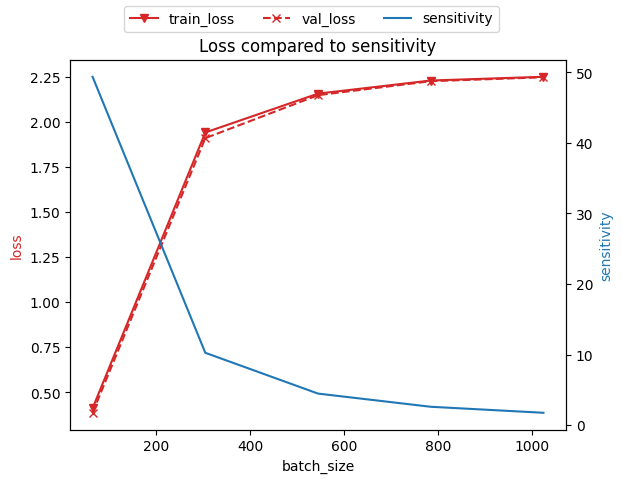

In [10]:
# columns=['epoch','train_loss','val_loss', 'train_acc', 'v_acc','batch_size', 'sensitivity']

fig, ax = plt.subplots()
ax.plot(fit_df.batch_size, fit_df.train_loss, color = 'tab:red', marker='v', label='train_loss')
ax.plot(fit_df.batch_size, fit_df.val_loss, color= 'tab:red', marker='x', linestyle='dashed', label='val_loss')
ax.set_xlabel('batch_size')
ax.set_ylabel('loss', color='tab:red')

ax2 = ax.twinx()
ax2.plot(fit_df.batch_size, fit_df.sensitivity, color='tab:blue', label='sensitivity')
ax2.set_ylabel('sensitivity', color='tab:blue')
plt.title('Loss compared to sensitivity')
fig.legend(loc='upper center', ncols = 3)






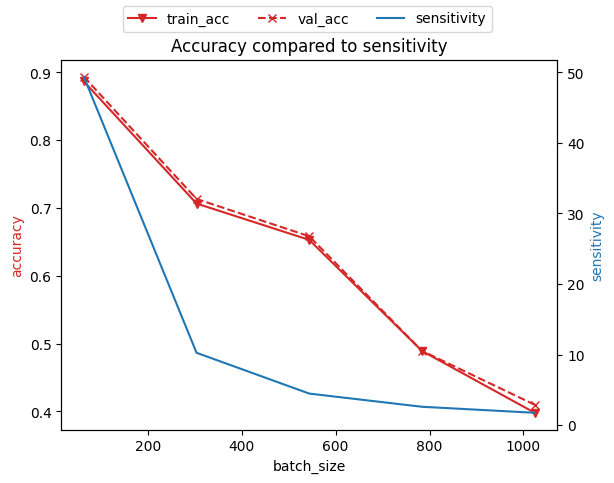

In [11]:
fig2, ax3 = plt.subplots()
ax3.plot(fit_df.batch_size, fit_df.train_acc, color = 'tab:red', marker='v', label='train_acc')
ax3.plot(fit_df.batch_size, fit_df.v_acc, color= 'tab:red', marker='x', linestyle='dashed', label='val_acc')
ax3.set_xlabel('batch_size')
ax3.set_ylabel('accuracy', color='tab:red')

ax3 = ax3.twinx()
ax3.plot(fit_df.batch_size, fit_df.sensitivity, color='tab:blue', label='sensitivity')
ax3.set_ylabel('sensitivity', color='tab:blue')
plt.title('Accuracy compared to sensitivity')
fig2.legend(loc='upper center', ncols = 3)
